In [1]:
import json
import pickle

from scipy.sparse import coo_matrix, csr_matrix, csc_matrix
from scipy.linalg import norm

from sklearn.decomposition import PCA, TruncatedSVD

from matplotlib import pyplot as plt
from IPython.display import HTML, display
import pandas as pd
import numpy as np


In [2]:
with open("stored_variables/user_subreddit_tf.pickle", "rb") as f:
    subreddit_tf = pickle.load(f)

In [3]:
with open("stored_variables/user_subreddit_df_mat.pickle", "rb") as f:
    subreddit_df_mat = pickle.load(f)

In [4]:
with open("stored_variables/user_subreddit_tf_auths.pickle", "rb") as f:
    author_names = pickle.load(f)

In [5]:
with open("stored_variables/user_subreddit_tf_subreddit_names.pickle", "rb") as f:
    subreddit_reverse_dict = pickle.load(f)

## Cosine similarity

In [7]:
subreddit_tf_c = coo_matrix(subreddit_tf)

In [8]:
subreddit_df_c = coo_matrix(subreddit_df_mat)

In [9]:
subreddit_idf = np.log(subreddit_df_c.sum() / (subreddit_df_c.sum(axis=0) + 1))

In [10]:
subreddit_tfidf = csr_matrix(subreddit_tf_c.multiply(subreddit_idf))

In [11]:
subreddit_tfidf_norms = np.zeros(subreddit_tfidf.shape[0])

In [12]:
for i in range(20):
    subreddit_tfidf_norms[i*1000 : (i+1) * 1000] = norm(subreddit_tfidf[i*1000 : (i+1) * 1000].toarray(), axis=1)

In [13]:
subreddit_tfidf_normalized = csr_matrix(subreddit_tfidf / subreddit_tfidf_norms[:, np.newaxis])

In [14]:
subreddit_cosine_sims = np.zeros((subreddit_tfidf.shape[0], subreddit_tfidf.shape[0]))

In [15]:
for i in range(20):
    chunk1 = subreddit_tfidf_normalized[i*1000 : (i+1)*1000, :]
    for j in range(20):
        chunk2 = subreddit_tfidf_normalized[j*1000 : (j+1)*1000, :]
        subreddit_cosine_sims[i*1000 : (i+1)*1000, j*1000 : (j+1)*1000] = chunk1.dot(csc_matrix(chunk2.T)).toarray()


In [16]:
for i in range(subreddit_tfidf.shape[0]):
    subreddit_cosine_sims[i,i] = 0

In [19]:
# with open("stored_variables/user_subreddit_tfidf_cossims.pickle", "wb") as f:
#     pickle.dump(subreddit_cosine_sims, f)
with open("stored_variables/user_subreddit_tfidf_cossims.pickle", "rb") as f:
    subreddit_cosine_sims = pickle.load(f)

In [20]:
most_similar_user = np.zeros(subreddit_tfidf.shape[0], dtype = np.int32)

In [21]:
for i in range(subreddit_tfidf.shape[0]):
    most_similar_user[i] = np.argsort(subreddit_cosine_sims[i])[-1]

In [22]:
most_similar_user[:10]

array([17655,    16,  6234,   202, 16449, 16449,   946,    20, 12246,
         143], dtype=int32)

In [23]:
[subreddit_cosine_sims[i, most_similar_user[i]] for i in range(10)]

[0.8121707495243793,
 0.6337431236865456,
 0.7519535958858542,
 0.866248873336835,
 0.8842001371009686,
 0.640120700372724,
 0.6579174327963478,
 0.9480065628775193,
 0.9820935090201509,
 0.7914165081149797]

## Check similarities by subreddits authors commented in

In [34]:
author_reverse_dict = {author_names[i]:i for i in range(len(author_names))}

In [35]:
num_sanders = {k:(subreddit_tf[author_reverse_dict[k], subreddit_reverse_dict['sandersforpresident']]) for k in author_names}
num_trump = {k:(subreddit_tf[author_reverse_dict[k], subreddit_reverse_dict['the_donald']]) for k in author_names}
num_clinton = {k:(subreddit_tf[author_reverse_dict[k], subreddit_reverse_dict['hillaryclinton']]) for k in author_names}
num_politics = {k:(subreddit_tf[author_reverse_dict[k], subreddit_reverse_dict['politics']]) for k in author_names}


In [36]:
comment_threshold = 10

In [37]:
sanders_user_indices = [i for i in range(subreddit_tf.shape[0]) if num_sanders[author_names[i]] >= comment_threshold]
trump_user_indices = [i for i in range(subreddit_tf.shape[0]) if num_trump[author_names[i]] >= comment_threshold]
clinton_user_indices = [i for i in range(subreddit_tf.shape[0]) if num_clinton[author_names[i]] >= comment_threshold]

In [38]:
none_user_indices = [i for i in range(subreddit_tf.shape[0]) if num_sanders[author_names[i]] == 0 and 
                     num_trump[author_names[i]] == 0 and
                     num_clinton[author_names[i]] == 0]

In [27]:
print(len(sanders_user_indices))
print(len(trump_user_indices))
print(len(clinton_user_indices))
print(len(none_user_indices))

1557
919
137
12958


In [28]:
print(len(set(sanders_user_indices).intersection(trump_user_indices)))
print(len(set(sanders_user_indices).intersection(clinton_user_indices)))
print(len(set(trump_user_indices).intersection(clinton_user_indices)))

206
73
18


In [29]:
np.sum(subreddit_cosine_sims[sanders_user_indices, :][:,sanders_user_indices]) / \
(len(sanders_user_indices) * (len(sanders_user_indices)-1))

0.138818073116637

In [30]:
np.sum(subreddit_cosine_sims[trump_user_indices, :][:,trump_user_indices]) / \
(len(trump_user_indices) * (len(trump_user_indices)-1))

0.14352057932099493

In [31]:
np.sum(subreddit_cosine_sims[clinton_user_indices, :][:,clinton_user_indices]) / \
(len(clinton_user_indices) * (len(clinton_user_indices)-1))

0.12949415279378929

In [32]:
np.sum(subreddit_cosine_sims[none_user_indices, :][:,none_user_indices]) / \
(len(none_user_indices) * (len(none_user_indices)-1))

0.0982426762905685

In [33]:
np.sum(subreddit_cosine_sims) / (subreddit_cosine_sims.shape[0] * (subreddit_cosine_sims.shape[1] - 1))

0.09393301351386252

In [34]:
print(np.sum(subreddit_cosine_sims[sanders_user_indices, :][:,trump_user_indices]) / \
((len(sanders_user_indices) * len(trump_user_indices)) - \
len(set(sanders_user_indices).intersection(trump_user_indices))))

print(np.sum(subreddit_cosine_sims[sanders_user_indices, :][:,clinton_user_indices]) / \
((len(sanders_user_indices) * len(clinton_user_indices)) - \
len(set(sanders_user_indices).intersection(clinton_user_indices))))

print(np.sum(subreddit_cosine_sims[clinton_user_indices, :][:,trump_user_indices]) / \
((len(clinton_user_indices) * len(trump_user_indices)) - \
len(set(clinton_user_indices).intersection(trump_user_indices))))

print()
print(np.sum(subreddit_cosine_sims[sanders_user_indices, :][:,none_user_indices]) / \
((len(sanders_user_indices) * len(none_user_indices))))
print(np.sum(subreddit_cosine_sims[trump_user_indices, :][:,none_user_indices]) / \
((len(trump_user_indices) * len(none_user_indices))))
print(np.sum(subreddit_cosine_sims[clinton_user_indices, :][:,none_user_indices]) / \
((len(clinton_user_indices) * len(none_user_indices))))

0.08808657193636073
0.10329472681020092
0.06596397218776581

0.0914953263809247
0.07740057658285684
0.06820820982044046


In [35]:
print(len(set(most_similar_user[sanders_user_indices]).intersection(sanders_user_indices)))
print(len(set(most_similar_user[sanders_user_indices]).intersection(sanders_user_indices))/len(sanders_user_indices))
print(len(set(most_similar_user[sanders_user_indices]).intersection(trump_user_indices)))
print(len(set(most_similar_user[sanders_user_indices]).intersection(trump_user_indices))/len(trump_user_indices))
print(len(set(most_similar_user[sanders_user_indices]).intersection(clinton_user_indices)))
print(len(set(most_similar_user[sanders_user_indices]).intersection(clinton_user_indices))/len(clinton_user_indices))
print()
print(len(set(most_similar_user[trump_user_indices]).intersection(sanders_user_indices)))
print(len(set(most_similar_user[trump_user_indices]).intersection(sanders_user_indices))/len(sanders_user_indices))
print(len(set(most_similar_user[trump_user_indices]).intersection(trump_user_indices)))
print(len(set(most_similar_user[trump_user_indices]).intersection(trump_user_indices))/len(trump_user_indices))
print(len(set(most_similar_user[trump_user_indices]).intersection(clinton_user_indices)))
print(len(set(most_similar_user[trump_user_indices]).intersection(clinton_user_indices))/len(clinton_user_indices))
print()
print(len(set(most_similar_user[clinton_user_indices]).intersection(sanders_user_indices)))
print(len(set(most_similar_user[clinton_user_indices]).intersection(sanders_user_indices))/len(sanders_user_indices))
print(len(set(most_similar_user[clinton_user_indices]).intersection(trump_user_indices)))
print(len(set(most_similar_user[clinton_user_indices]).intersection(trump_user_indices))/len(trump_user_indices))
print(len(set(most_similar_user[clinton_user_indices]).intersection(clinton_user_indices)))
print(len(set(most_similar_user[clinton_user_indices]).intersection(clinton_user_indices))/len(clinton_user_indices))



203
0.13037893384714194
62
0.06746463547334058
17
0.12408759124087591

60
0.038535645472061654
162
0.176278563656148
6
0.043795620437956206

24
0.015414258188824663
2
0.002176278563656148
16
0.11678832116788321


In [24]:
sanders_sanders_sims = []

for i in range(len(sanders_user_indices)):
    for j in range(i+1, len(sanders_user_indices)):
        sanders_sanders_sims.append(subreddit_cosine_sims[i,j])

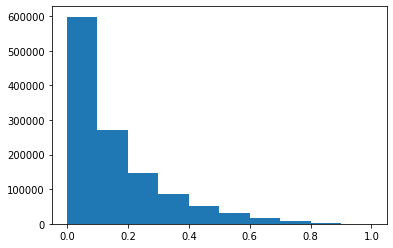

In [26]:
plt.hist(sanders_sanders_sims, range = (0, 1))
plt.show()

In [27]:
trump_trump_sims = []

for i in range(len(trump_user_indices)):
    for j in range(i+1, len(trump_user_indices)):
        trump_trump_sims.append(subreddit_cosine_sims[i,j])

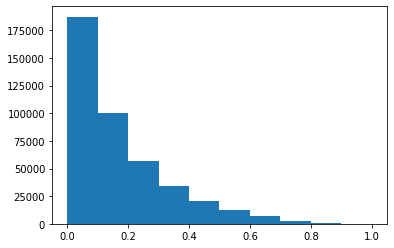

In [28]:
plt.hist(trump_trump_sims, range = (0,1))
plt.show()

In [29]:
clinton_clinton_sims = []

for i in range(len(clinton_user_indices)):
    for j in range(i+1, len(clinton_user_indices)):
        clinton_clinton_sims.append(subreddit_cosine_sims[i,j])

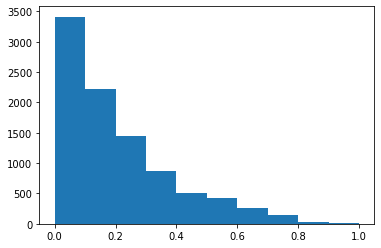

In [30]:
plt.hist(clinton_clinton_sims, range = (0,1))
plt.show()

## Use SVD

In [31]:
user_svd = TruncatedSVD(n_components = 100)
user_svd_points = user_svd.fit_transform(subreddit_tfidf)

In [32]:
user_svd_norms = np.zeros(subreddit_tfidf.shape[0])

In [33]:
for i in range(20):
    user_svd_norms[i*1000 : (i+1) * 1000] = norm(user_svd_points[i*1000 : (i+1) * 1000], axis=1)

In [34]:
user_svd_norms[:10]

array([ 1772.29306825,   880.05553517,  5449.37251059, 21327.21924213,
        3405.7815929 ,  2492.97130169,  1435.46953998,  9903.9773427 ,
         797.21534645,  7837.95866625])

In [35]:
user_svd_normalized = user_svd_points / user_svd_norms[:, np.newaxis]

In [37]:
svd_cosine_sims = np.zeros((subreddit_tfidf.shape[0], subreddit_tfidf.shape[0]))

In [38]:
for i in range(20):
    chunk1 = csr_matrix(user_svd_normalized[i*1000 : (i+1)*1000, :])
    for j in range(i,20):
        chunk2 = csc_matrix(user_svd_normalized[j*1000 : (j+1)*1000, :].T)
        svd_cosine_sims[i*1000 : (i+1)*1000, j*1000 : (j+1)*1000] = chunk1.dot(chunk2).toarray()


In [39]:
svd_cosine_sims[:10,:10]

array([[1.        , 0.59246596, 0.40779453, 0.62573905, 0.78517013,
        0.59846587, 0.7942294 , 0.83856833, 0.11139849, 0.76942935],
       [0.59246596, 1.        , 0.35113661, 0.69985353, 0.66269401,
        0.49089799, 0.69749409, 0.70741941, 0.08476321, 0.68826074],
       [0.40779453, 0.35113661, 1.        , 0.72695793, 0.21226189,
        0.36110115, 0.33938229, 0.35714633, 0.04896695, 0.35165091],
       [0.62573905, 0.69985353, 0.72695793, 1.        , 0.55679138,
        0.47879139, 0.67875937, 0.70909006, 0.07148385, 0.68080423],
       [0.78517013, 0.66269401, 0.21226189, 0.55679138, 1.        ,
        0.69421506, 0.90182752, 0.93546863, 0.13937695, 0.79031463],
       [0.59846587, 0.49089799, 0.36110115, 0.47879139, 0.69421506,
        1.        , 0.64387001, 0.63335388, 0.15537992, 0.66817856],
       [0.7942294 , 0.69749409, 0.33938229, 0.67875937, 0.90182752,
        0.64387001, 1.        , 0.93161911, 0.10436644, 0.85545156],
       [0.83856833, 0.70741941, 0.3571463

In [40]:
for i in range(subreddit_tfidf.shape[0]):
    svd_cosine_sims[i,i] = 0

In [41]:
for i in range(20):
    for j in range(i):
        svd_cosine_sims[i*1000 : (i+1)*1000, j*1000 : (j+1)*1000] = \
svd_cosine_sims[j*1000 : (j+1)*1000, i*1000 : (i+1)*1000].T

In [42]:
svd_cosine_sims[3872,10415]

0.5076858907101239

In [43]:
svd_cosine_sims[10415,3872]

0.5076858907101239

In [44]:
with open("stored_variables/user_subreddit_tfidf_cossims_svd.pickle", "wb") as f:
    pickle.dump(svd_cosine_sims, f)
    
# with open("stored_variables/user_subreddit_tfidf_cossims_svd.pickle", "rb") as f:
#     svd_cosine_sims = pickle.load(f)

In [45]:
most_similar_user_svd = np.zeros(subreddit_tfidf.shape[0], dtype = np.int32)

In [46]:
for i in range(subreddit_tfidf.shape[0]):
    most_similar_user_svd[i] = np.argsort(svd_cosine_sims[i])[-1]

In [47]:
most_similar_user_svd[:10]

array([   26,    16,   828,   946,    10,   387,    64,   942, 12012,
          43], dtype=int32)

In [48]:
[svd_cosine_sims[i, most_similar_user_svd[i]] for i in range(10)]

[0.9061768945263322,
 0.8616068119824877,
 0.9706806392880275,
 0.9853026705024586,
 0.9609889282358702,
 0.7715594661723298,
 0.95226511877232,
 0.9680187506441011,
 0.9877055443234641,
 0.9262354425226317]

In [49]:
np.sum(svd_cosine_sims[sanders_user_indices, :][:,sanders_user_indices]) / \
(len(sanders_user_indices) * (len(sanders_user_indices)-1))

0.2734861628342012

In [50]:
np.sum(svd_cosine_sims[trump_user_indices, :][:,trump_user_indices]) / \
(len(trump_user_indices) * (len(trump_user_indices)-1))

0.21710989100375805

In [51]:
np.sum(svd_cosine_sims[clinton_user_indices, :][:,clinton_user_indices]) / \
(len(clinton_user_indices) * (len(clinton_user_indices)-1))

0.21334667040884386

In [52]:
np.sum(svd_cosine_sims[none_user_indices, :][:,none_user_indices]) / \
(len(none_user_indices) * (len(none_user_indices)-1))

0.2539389270388249

In [53]:
np.sum(svd_cosine_sims) / (svd_cosine_sims.shape[0] * (svd_cosine_sims.shape[1] - 1))

0.24007926917094521

In [54]:
print(np.sum(svd_cosine_sims[sanders_user_indices, :][:,trump_user_indices]) / \
((len(sanders_user_indices) * len(trump_user_indices)) - \
len(set(sanders_user_indices).intersection(trump_user_indices))))

print(np.sum(svd_cosine_sims[sanders_user_indices, :][:,clinton_user_indices]) / \
((len(sanders_user_indices) * len(clinton_user_indices)) - \
len(set(sanders_user_indices).intersection(clinton_user_indices))))

print(np.sum(svd_cosine_sims[clinton_user_indices, :][:,trump_user_indices]) / \
((len(clinton_user_indices) * len(trump_user_indices)) - \
len(set(clinton_user_indices).intersection(trump_user_indices))))

print()
print(np.sum(svd_cosine_sims[sanders_user_indices, :][:,none_user_indices]) / \
((len(sanders_user_indices) * len(none_user_indices))))
print(np.sum(svd_cosine_sims[trump_user_indices, :][:,none_user_indices]) / \
((len(trump_user_indices) * len(none_user_indices))))
print(np.sum(svd_cosine_sims[clinton_user_indices, :][:,none_user_indices]) / \
((len(clinton_user_indices) * len(none_user_indices))))

0.20419046548735034
0.21317712992273619
0.17377190941889184

0.21264203696022654
0.21382045741031738
0.16923178232681446


In [55]:
print(len(set(most_similar_user_svd[sanders_user_indices]).intersection(sanders_user_indices)))
print(len(set(most_similar_user_svd[sanders_user_indices]).intersection(sanders_user_indices))/len(sanders_user_indices))
print(len(set(most_similar_user_svd[sanders_user_indices]).intersection(trump_user_indices)))
print(len(set(most_similar_user_svd[sanders_user_indices]).intersection(trump_user_indices))/len(trump_user_indices))
print(len(set(most_similar_user_svd[sanders_user_indices]).intersection(clinton_user_indices)))
print(len(set(most_similar_user_svd[sanders_user_indices]).intersection(clinton_user_indices))/len(clinton_user_indices))
print()
print(len(set(most_similar_user_svd[trump_user_indices]).intersection(sanders_user_indices)))
print(len(set(most_similar_user_svd[trump_user_indices]).intersection(sanders_user_indices))/len(sanders_user_indices))
print(len(set(most_similar_user_svd[trump_user_indices]).intersection(trump_user_indices)))
print(len(set(most_similar_user_svd[trump_user_indices]).intersection(trump_user_indices))/len(trump_user_indices))
print(len(set(most_similar_user_svd[trump_user_indices]).intersection(clinton_user_indices)))
print(len(set(most_similar_user_svd[trump_user_indices]).intersection(clinton_user_indices))/len(clinton_user_indices))
print()
print(len(set(most_similar_user_svd[clinton_user_indices]).intersection(sanders_user_indices)))
print(len(set(most_similar_user_svd[clinton_user_indices]).intersection(sanders_user_indices))/len(sanders_user_indices))
print(len(set(most_similar_user_svd[clinton_user_indices]).intersection(trump_user_indices)))
print(len(set(most_similar_user_svd[clinton_user_indices]).intersection(trump_user_indices))/len(trump_user_indices))
print(len(set(most_similar_user_svd[clinton_user_indices]).intersection(clinton_user_indices)))
print(len(set(most_similar_user_svd[clinton_user_indices]).intersection(clinton_user_indices))/len(clinton_user_indices))



385
0.2472703917790623
84
0.09140369967355821
23
0.1678832116788321

77
0.04945407835581246
129
0.14036996735582155
9
0.06569343065693431

32
0.020552344251766216
8
0.008705114254624592
12
0.08759124087591241


In [71]:
sanders_sanders_sims = []

for i in range(len(sanders_user_indices)):
    for j in range(i+1, len(sanders_user_indices)):
        sanders_sanders_sims.append(svd_cosine_sims[i,j])

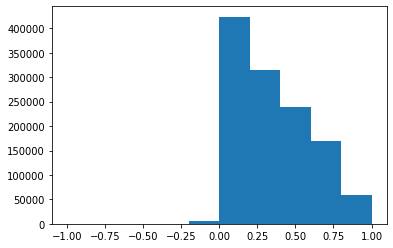

In [72]:
plt.hist(sanders_sanders_sims, range = (-1,1))
plt.show()

In [73]:
trump_trump_sims = []

for i in range(len(trump_user_indices)):
    for j in range(i+1, len(trump_user_indices)):
        trump_trump_sims.append(svd_cosine_sims[i,j])

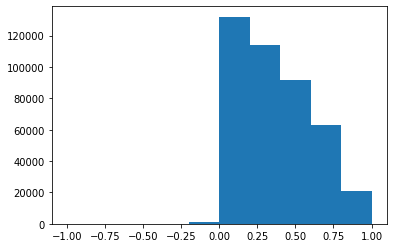

In [74]:
plt.hist(trump_trump_sims, range = (-1,1) )
plt.show()

In [75]:
clinton_clinton_sims = []

for i in range(len(clinton_user_indices)):
    for j in range(i+1, len(clinton_user_indices)):
        clinton_clinton_sims.append(svd_cosine_sims[i,j])

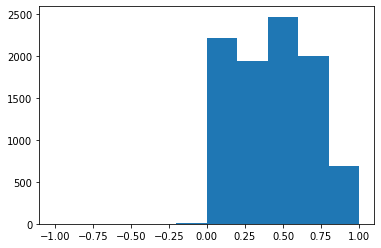

In [76]:
plt.hist(clinton_clinton_sims, range = (-1,1))
plt.show()

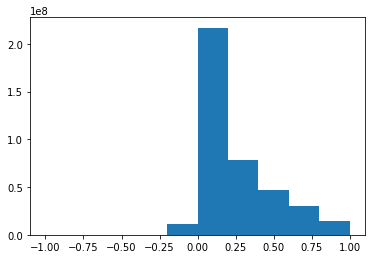

In [77]:
plt.hist(svd_cosine_sims.flatten(), range=(-1,1))
plt.show()

In [78]:
most_similar_50_users_svd = np.zeros((subreddit_tfidf.shape[0],50), dtype = np.int32)

for i in range(subreddit_tfidf.shape[0]):
    most_similar_50_users_svd[i] = np.flip(np.argsort(svd_cosine_sims[i])[-50:])


In [79]:
most_similar_50_users_svd[0]

array([  26,   14,    7,  531,   35,   10,  882,  942,    6,  102,    4,
        494,   48,  111,  131,  353,    9,  418,   43,  288,   64,   20,
        105,   55,  839,   37,   88,  168,  383,  571,  276,   62,  644,
        425,   22, 1178,   70,   93,   44,   95,  473,  504,  143,  307,
         80,   85,  327,  109,  609, 1055], dtype=int32)

In [80]:
most_similar_50_set = [set(i) for i in most_similar_50_users_svd]

In [81]:
print(np.mean([len(most_similar_50_set[i].intersection(sanders_user_indices)) for i in sanders_user_indices]))
print(np.median([len(most_similar_50_set[i].intersection(sanders_user_indices)) for i in sanders_user_indices]))
print(np.mean([num_sanders[author_names[i]] for i in sanders_user_indices]))
print(np.mean([num_sanders[author_names[i]] for i in sanders_user_indices if len(most_similar_50_set[i].intersection(sanders_user_indices)) >= 10]))


14.33140655105973
6.0
103.33847141939627
203.71379310344827


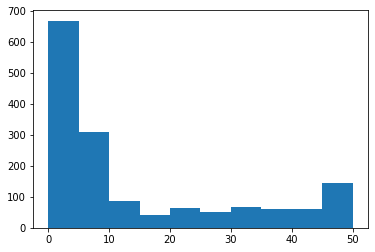

In [82]:
plt.hist([len(most_similar_50_set[i].intersection(sanders_user_indices)) for i in sanders_user_indices], range = (0,50))
plt.show()

In [83]:
print(sum([1 for i in sanders_user_indices if len(most_similar_50_set[i].intersection(sanders_user_indices)) >= 10]))
print(sum([1 for i in sanders_user_indices if len(most_similar_50_set[i].intersection(sanders_user_indices)) >= 30]))

580
335


7.269858541893362
3.0
140
77
97.14907508161045
253.77857142857144


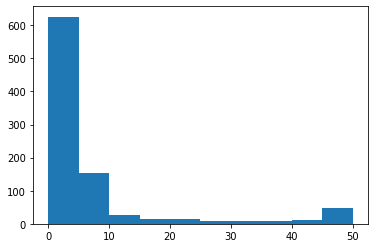

In [84]:
print(np.mean([len(most_similar_50_set[i].intersection(trump_user_indices)) for i in trump_user_indices]))
print(np.median([len(most_similar_50_set[i].intersection(trump_user_indices)) for i in trump_user_indices]))
print(sum([1 for i in trump_user_indices if len(most_similar_50_set[i].intersection(trump_user_indices)) >= 10]))
print(sum([1 for i in trump_user_indices if len(most_similar_50_set[i].intersection(trump_user_indices)) >= 30]))
print(np.mean([num_trump[author_names[i]] for i in trump_user_indices]))
print(np.mean([num_trump[author_names[i]] for i in trump_user_indices if len(most_similar_50_set[i].intersection(trump_user_indices)) >= 10]))

plt.hist([len(most_similar_50_set[i].intersection(trump_user_indices)) for i in trump_user_indices], range = (0,50))
plt.show()

1.8759124087591241
1.0
2
0
95.81751824817518
152.5


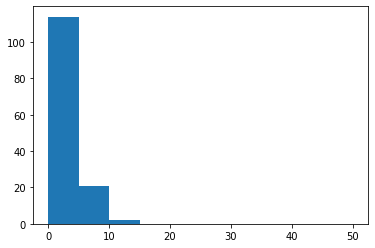

In [85]:
print(np.mean([len(most_similar_50_set[i].intersection(clinton_user_indices)) for i in clinton_user_indices]))
print(np.median([len(most_similar_50_set[i].intersection(clinton_user_indices)) for i in clinton_user_indices]))
print(sum([1 for i in clinton_user_indices if len(most_similar_50_set[i].intersection(clinton_user_indices)) >= 10]))
print(sum([1 for i in clinton_user_indices if len(most_similar_50_set[i].intersection(clinton_user_indices)) >= 30]))
print(np.mean([num_clinton[author_names[i]] for i in clinton_user_indices]))
print(np.mean([num_clinton[author_names[i]] for i in clinton_user_indices if len(most_similar_50_set[i].intersection(clinton_user_indices)) >= 10]))


plt.hist([len(most_similar_50_set[i].intersection(clinton_user_indices)) for i in clinton_user_indices], range = (0,50))
plt.show()

## Try with Music and HipHopHeads

In [86]:
num_music = {k:(subreddit_tf[author_reverse_dict[k], subreddit_reverse_dict['music']]) for k in author_names}
num_hhh = {k:(subreddit_tf[author_reverse_dict[k], subreddit_reverse_dict['hiphopheads']]) for k in author_names}


In [87]:
music_user_indices = [i for i in range(subreddit_tf.shape[0]) if num_music[author_names[i]] >= comment_threshold]
print(len(music_user_indices))
hhh_user_indices = [i for i in range(subreddit_tf.shape[0]) if num_hhh[author_names[i]] >= comment_threshold]
print(len(hhh_user_indices))


2176
590


In [88]:
np.sum(svd_cosine_sims[music_user_indices, :][:,music_user_indices]) / \
(len(music_user_indices) * (len(music_user_indices)-1))

0.3541934109154698

In [89]:
np.sum(svd_cosine_sims[hhh_user_indices, :][:,hhh_user_indices]) / \
(len(hhh_user_indices) * (len(hhh_user_indices)-1))

0.25303707224553496

In [90]:
print(np.sum(svd_cosine_sims[music_user_indices, :][:,hhh_user_indices]) / \
((len(music_user_indices) * len(hhh_user_indices)) - \
len(set(music_user_indices).intersection(hhh_user_indices))))


0.2368393542015716


In [91]:
print(len(set(most_similar_user_svd[music_user_indices]).intersection(music_user_indices)))
print(len(set(most_similar_user_svd[music_user_indices]).intersection(music_user_indices))/len(music_user_indices))
print(len(set(most_similar_user_svd[music_user_indices]).intersection(hhh_user_indices)))
print(len(set(most_similar_user_svd[music_user_indices]).intersection(hhh_user_indices))/len(hhh_user_indices))

print(len(set(most_similar_user_svd[hhh_user_indices]).intersection(hhh_user_indices)))
print(len(set(most_similar_user_svd[hhh_user_indices]).intersection(hhh_user_indices))/len(hhh_user_indices))
print(len(set(most_similar_user_svd[hhh_user_indices]).intersection(music_user_indices)))
print(len(set(most_similar_user_svd[hhh_user_indices]).intersection(music_user_indices))/len(music_user_indices))

356
0.1636029411764706
74
0.12542372881355932
143
0.2423728813559322
101
0.04641544117647059


In [92]:
music_music_sims = []

for i in range(len(music_user_indices)):
    for j in range(i+1, len(music_user_indices)):
        music_music_sims.append(svd_cosine_sims[i,j])

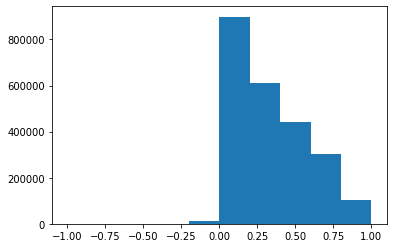

In [93]:
plt.hist(music_music_sims, range = (-1,1))
plt.show()

In [94]:
hhh_hhh_sims = []

for i in range(len(hhh_user_indices)):
    for j in range(i+1, len(hhh_user_indices)):
        hhh_hhh_sims.append(svd_cosine_sims[i,j])

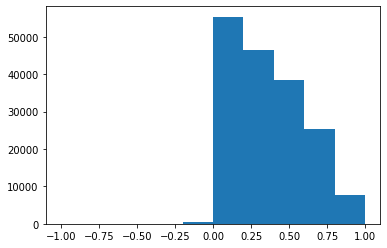

In [95]:
plt.hist(hhh_hhh_sims, range = (-1,1) )
plt.show()

8.952205882352942
8.0
907
0
37.385110294117645
39.487320837927236


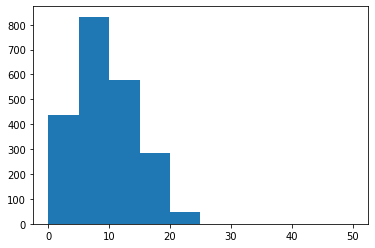

In [96]:
print(np.mean([len(most_similar_50_set[i].intersection(music_user_indices)) for i in music_user_indices]))
print(np.median([len(most_similar_50_set[i].intersection(music_user_indices)) for i in music_user_indices]))
print(sum([1 for i in music_user_indices if len(most_similar_50_set[i].intersection(music_user_indices)) >= 10]))
print(sum([1 for i in music_user_indices if len(most_similar_50_set[i].intersection(music_user_indices)) >= 30]))
print(np.mean([num_music[author_names[i]] for i in music_user_indices]))
print(np.mean([num_music[author_names[i]] for i in music_user_indices if len(most_similar_50_set[i].intersection(music_user_indices)) >= 10]))

plt.hist([len(most_similar_50_set[i].intersection(music_user_indices)) for i in music_user_indices], range = (0,50))
plt.show()

12.686440677966102
4.0
179
119
128.61016949152543
287.92737430167597


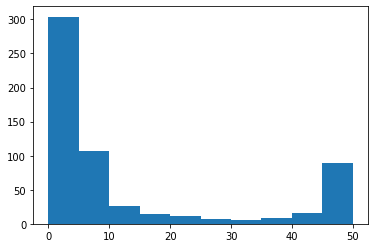

In [97]:
print(np.mean([len(most_similar_50_set[i].intersection(hhh_user_indices)) for i in hhh_user_indices]))
print(np.median([len(most_similar_50_set[i].intersection(hhh_user_indices)) for i in hhh_user_indices]))
print(sum([1 for i in hhh_user_indices if len(most_similar_50_set[i].intersection(hhh_user_indices)) >= 10]))
print(sum([1 for i in hhh_user_indices if len(most_similar_50_set[i].intersection(hhh_user_indices)) >= 30]))
print(np.mean([num_hhh[author_names[i]] for i in hhh_user_indices]))
print(np.mean([num_hhh[author_names[i]] for i in hhh_user_indices if len(most_similar_50_set[i].intersection(hhh_user_indices)) >= 10]))

plt.hist([len(most_similar_50_set[i].intersection(hhh_user_indices)) for i in hhh_user_indices], range = (0,50))
plt.show()

## Check if similarities persist after removing SFP, TD, HC

In [14]:
subreddit_tfidf_modified = csc_matrix(subreddit_tfidf)
subreddit_tfidf_modified[:, subreddit_reverse_dict['sandersforpresident']] = 0
subreddit_tfidf_modified[:, subreddit_reverse_dict['the_donald']] = 0
subreddit_tfidf_modified[:, subreddit_reverse_dict['hillaryclinton']] = 0
subreddit_tfidf_modified = csr_matrix(subreddit_tfidf_modified)

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [16]:
user_svd_m = TruncatedSVD(n_components = 100)
user_svd_points_m = user_svd_m.fit_transform(subreddit_tfidf_modified)

In [17]:
user_svd_norms_m = np.zeros(subreddit_tfidf.shape[0])

In [18]:
for i in range(20):
    user_svd_norms_m[i*1000 : (i+1) * 1000] = norm(user_svd_points_m[i*1000 : (i+1) * 1000], axis=1)

In [19]:
user_svd_norms_m[:10]

array([ 1793.44357288,   761.0551272 ,  5456.60617868, 21367.63714488,
        3457.99131783,  2473.13588006,  1451.52846776, 10076.08660647,
         801.22764434,  7841.59335968])

In [20]:
user_svd_normalized_m = user_svd_points_m / user_svd_norms_m[:, np.newaxis]

In [21]:
svd_cosine_sims_m = np.zeros((subreddit_tfidf.shape[0], subreddit_tfidf.shape[0]))

In [22]:
for i in range(20):
    chunk1 = csr_matrix(user_svd_normalized_m[i*1000 : (i+1)*1000, :])
    for j in range(i,20):
        chunk2 = csc_matrix(user_svd_normalized_m[j*1000 : (j+1)*1000, :].T)
        svd_cosine_sims_m[i*1000 : (i+1)*1000, j*1000 : (j+1)*1000] = chunk1.dot(chunk2).toarray()


In [23]:
svd_cosine_sims_m[:10,:10]

array([[1.        , 0.69819874, 0.40739394, 0.62832866, 0.78634988,
        0.58905949, 0.79823031, 0.84207338, 0.10262892, 0.76900572],
       [0.69819874, 1.        , 0.40557935, 0.81964641, 0.78528008,
        0.58110145, 0.82243399, 0.83525074, 0.1006453 , 0.80725829],
       [0.40739394, 0.40557935, 1.        , 0.72755832, 0.21183822,
        0.35326269, 0.34223893, 0.35644356, 0.04452097, 0.35418931],
       [0.62832866, 0.81964641, 0.72755832, 1.        , 0.55982262,
        0.48146106, 0.68080072, 0.70859146, 0.0662739 , 0.68135108],
       [0.78634988, 0.78528008, 0.21183822, 0.55982262, 1.        ,
        0.68517481, 0.90404729, 0.93720192, 0.13325858, 0.79009851],
       [0.58905949, 0.58110145, 0.35326269, 0.48146106, 0.68517481,
        1.        , 0.64212969, 0.6255566 , 0.16437649, 0.68232976],
       [0.79823031, 0.82243399, 0.34223893, 0.68080072, 0.90404729,
        0.64212969, 1.        , 0.93279784, 0.09664204, 0.85173772],
       [0.84207338, 0.83525074, 0.3564435

In [24]:
for i in range(subreddit_tfidf.shape[0]):
    svd_cosine_sims_m[i,i] = 0

In [25]:
for i in range(20):
    for j in range(i):
        svd_cosine_sims_m[i*1000 : (i+1)*1000, j*1000 : (j+1)*1000] = \
svd_cosine_sims_m[j*1000 : (j+1)*1000, i*1000 : (i+1)*1000].T

In [26]:
svd_cosine_sims_m[3872,10415]

0.5095418193633449

In [27]:
svd_cosine_sims_m[10415,3872]

0.5095418193633449

In [28]:
most_similar_user_svd_m = np.zeros(subreddit_tfidf.shape[0], dtype = np.int32)

In [29]:
for i in range(subreddit_tfidf.shape[0]):
    most_similar_user_svd_m[i] = np.argsort(svd_cosine_sims_m[i])[-1]

In [30]:
most_similar_user_svd_m[:10]

array([   26,    46, 15665,   946,    10,   387,    64,   942, 12012,
          48], dtype=int32)

In [31]:
[svd_cosine_sims_m[i, most_similar_user_svd_m[i]] for i in range(10)]

[0.9016211896937636,
 0.9341721233427274,
 0.9686075509210403,
 0.9838868298324015,
 0.9634213755201699,
 0.7636870576672039,
 0.9541651378518858,
 0.9675890307830424,
 0.9856898533923323,
 0.9279269373501593]

In [39]:
np.sum(svd_cosine_sims_m[sanders_user_indices, :][:,sanders_user_indices]) / \
(len(sanders_user_indices) * (len(sanders_user_indices)-1))

0.263164447561359

In [40]:
np.sum(svd_cosine_sims_m[trump_user_indices, :][:,trump_user_indices]) / \
(len(trump_user_indices) * (len(trump_user_indices)-1))

0.21623163807739687

In [41]:
np.sum(svd_cosine_sims_m[clinton_user_indices, :][:,clinton_user_indices]) / \
(len(clinton_user_indices) * (len(clinton_user_indices)-1))

0.22392113887854653

In [42]:
np.sum(svd_cosine_sims_m[none_user_indices, :][:,none_user_indices]) / \
(len(none_user_indices) * (len(none_user_indices)-1))

0.2540551920083579

In [43]:
np.sum(svd_cosine_sims_m) / (svd_cosine_sims_m.shape[0] * (svd_cosine_sims_m.shape[1] - 1))

0.24675364407409253

In [44]:
print(np.sum(svd_cosine_sims_m[sanders_user_indices, :][:,trump_user_indices]) / \
((len(sanders_user_indices) * len(trump_user_indices)) - \
len(set(sanders_user_indices).intersection(trump_user_indices))))

print(np.sum(svd_cosine_sims_m[sanders_user_indices, :][:,clinton_user_indices]) / \
((len(sanders_user_indices) * len(clinton_user_indices)) - \
len(set(sanders_user_indices).intersection(clinton_user_indices))))

print(np.sum(svd_cosine_sims_m[clinton_user_indices, :][:,trump_user_indices]) / \
((len(clinton_user_indices) * len(trump_user_indices)) - \
len(set(clinton_user_indices).intersection(trump_user_indices))))

print()
print(np.sum(svd_cosine_sims_m[sanders_user_indices, :][:,none_user_indices]) / \
((len(sanders_user_indices) * len(none_user_indices))))
print(np.sum(svd_cosine_sims_m[trump_user_indices, :][:,none_user_indices]) / \
((len(trump_user_indices) * len(none_user_indices))))
print(np.sum(svd_cosine_sims_m[clinton_user_indices, :][:,none_user_indices]) / \
((len(clinton_user_indices) * len(none_user_indices))))

0.23611804227863864
0.22082826112713277
0.19205718653634363

0.2493614891030537
0.2255019885807114
0.18887873578199213


In [45]:
print(len(set(most_similar_user_svd_m[sanders_user_indices]).intersection(sanders_user_indices)))
print(len(set(most_similar_user_svd_m[sanders_user_indices]).intersection(sanders_user_indices))/len(sanders_user_indices))
print(len(set(most_similar_user_svd_m[sanders_user_indices]).intersection(trump_user_indices)))
print(len(set(most_similar_user_svd_m[sanders_user_indices]).intersection(trump_user_indices))/len(trump_user_indices))
print(len(set(most_similar_user_svd_m[sanders_user_indices]).intersection(clinton_user_indices)))
print(len(set(most_similar_user_svd_m[sanders_user_indices]).intersection(clinton_user_indices))/len(clinton_user_indices))
print()
print(len(set(most_similar_user_svd_m[trump_user_indices]).intersection(sanders_user_indices)))
print(len(set(most_similar_user_svd_m[trump_user_indices]).intersection(sanders_user_indices))/len(sanders_user_indices))
print(len(set(most_similar_user_svd_m[trump_user_indices]).intersection(trump_user_indices)))
print(len(set(most_similar_user_svd_m[trump_user_indices]).intersection(trump_user_indices))/len(trump_user_indices))
print(len(set(most_similar_user_svd_m[trump_user_indices]).intersection(clinton_user_indices)))
print(len(set(most_similar_user_svd_m[trump_user_indices]).intersection(clinton_user_indices))/len(clinton_user_indices))
print()
print(len(set(most_similar_user_svd_m[clinton_user_indices]).intersection(sanders_user_indices)))
print(len(set(most_similar_user_svd_m[clinton_user_indices]).intersection(sanders_user_indices))/len(sanders_user_indices))
print(len(set(most_similar_user_svd_m[clinton_user_indices]).intersection(trump_user_indices)))
print(len(set(most_similar_user_svd_m[clinton_user_indices]).intersection(trump_user_indices))/len(trump_user_indices))
print(len(set(most_similar_user_svd_m[clinton_user_indices]).intersection(clinton_user_indices)))
print(len(set(most_similar_user_svd_m[clinton_user_indices]).intersection(clinton_user_indices))/len(clinton_user_indices))



177
0.11368015414258188
98
0.10663764961915125
27
0.19708029197080293

86
0.05523442517662171
66
0.07181719260065289
7
0.051094890510948905

11
0.007064868336544637
10
0.01088139281828074
4
0.029197080291970802


In [46]:
sanders_sanders_sims_m = []

for i in range(len(sanders_user_indices)):
    for j in range(i+1, len(sanders_user_indices)):
        sanders_sanders_sims_m.append(svd_cosine_sims_m[i,j])

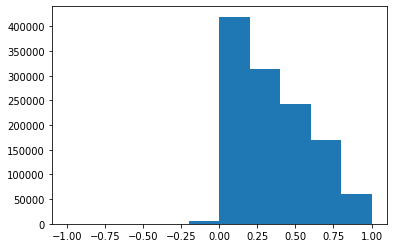

In [47]:
plt.hist(sanders_sanders_sims_m, range = (-1,1))
plt.show()

In [48]:
trump_trump_sims_m = []

for i in range(len(trump_user_indices)):
    for j in range(i+1, len(trump_user_indices)):
        trump_trump_sims_m.append(svd_cosine_sims_m[i,j])

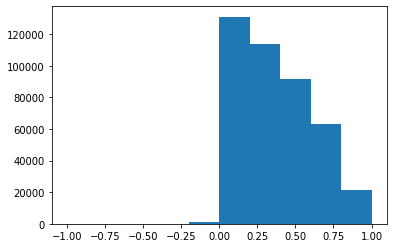

In [49]:
plt.hist(trump_trump_sims_m, range = (-1,1) )
plt.show()

In [50]:
clinton_clinton_sims_m = []

for i in range(len(clinton_user_indices)):
    for j in range(i+1, len(clinton_user_indices)):
        clinton_clinton_sims_m.append(svd_cosine_sims_m[i,j])

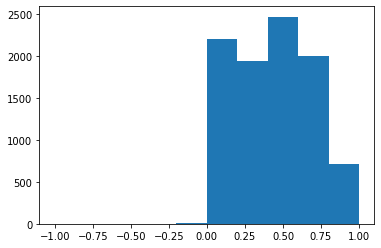

In [51]:
plt.hist(clinton_clinton_sims_m, range = (-1,1))
plt.show()

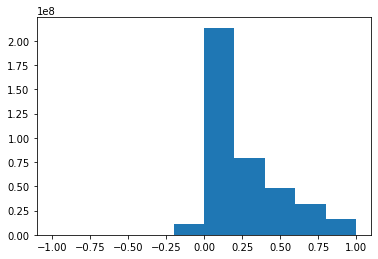

In [53]:
plt.hist(svd_cosine_sims_m.flatten(), range=(-1,1))
plt.show()

In [54]:
most_similar_50_users_svd_m = np.zeros((subreddit_tfidf.shape[0],50), dtype = np.int32)

for i in range(subreddit_tfidf.shape[0]):
    most_similar_50_users_svd_m[i] = np.flip(np.argsort(svd_cosine_sims_m[i])[-50:])


In [55]:
most_similar_50_users_svd_m[0]

array([  26,   14,    7,  531,   10,  942,  882,    6,   35,  102,  494,
          4,  111,  353,   48,   16,   43,  418,  109,    9,   20,   64,
        288,  131,  105,   55,   37,  571,   88,  839,  276,  644,   62,
        425,  168,   22, 1178,  307,   44,  504,  240,  473,   80,   93,
         95, 1055, 1532,   85,  383,   70], dtype=int32)

In [56]:
most_similar_50_set_m = [set(i) for i in most_similar_50_users_svd_m]

In [57]:
print(np.mean([len(most_similar_50_set_m[i].intersection(sanders_user_indices)) for i in sanders_user_indices]))
print(np.median([len(most_similar_50_set_m[i].intersection(sanders_user_indices)) for i in sanders_user_indices]))
print(np.mean([num_sanders[author_names[i]] for i in sanders_user_indices]))
print(np.mean([num_sanders[author_names[i]] for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 5]))
print(np.mean([num_sanders[author_names[i]] for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 10]))


5.619139370584457
4.0
103.33847141939627
129.4787234042553
173.056


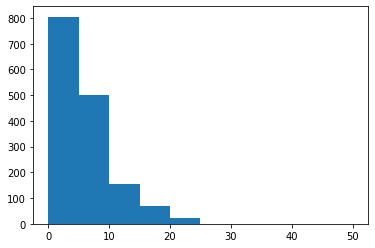

In [58]:
plt.hist([len(most_similar_50_set_m[i].intersection(sanders_user_indices)) for i in sanders_user_indices], range = (0,50))
plt.show()

In [65]:
print(sum([1 for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 5]))
print(sum([1 for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 10]))
print(sum([1 for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 30]))

752
250
0


3.189336235038085
3.0
215
18
0
97.14907508161045
109.76744186046511
49.111111111111114


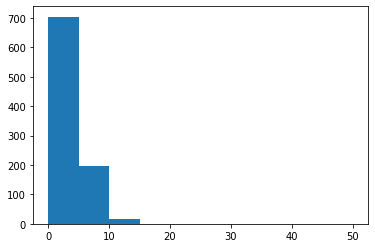

In [60]:
print(np.mean([len(most_similar_50_set_m[i].intersection(trump_user_indices)) for i in trump_user_indices]))
print(np.median([len(most_similar_50_set_m[i].intersection(trump_user_indices)) for i in trump_user_indices]))
print(sum([1 for i in trump_user_indices if len(most_similar_50_set_m[i].intersection(trump_user_indices)) >= 5]))
print(sum([1 for i in trump_user_indices if len(most_similar_50_set_m[i].intersection(trump_user_indices)) >= 10]))
print(sum([1 for i in trump_user_indices if len(most_similar_50_set_m[i].intersection(trump_user_indices)) >= 30]))
print(np.mean([num_trump[author_names[i]] for i in trump_user_indices]))
print(np.mean([num_trump[author_names[i]] for i in trump_user_indices if len(most_similar_50_set_m[i].intersection(trump_user_indices)) >= 5]))
print(np.mean([num_trump[author_names[i]] for i in trump_user_indices if len(most_similar_50_set_m[i].intersection(trump_user_indices)) >= 10]))

plt.hist([len(most_similar_50_set_m[i].intersection(trump_user_indices)) for i in trump_user_indices], range = (0,50))
plt.show()

1.489051094890511
1.0
20
0
0


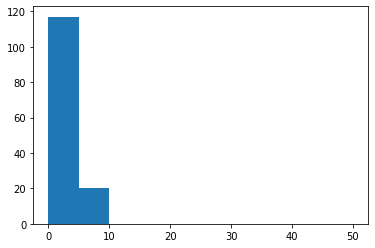

In [61]:
print(np.mean([len(most_similar_50_set_m[i].intersection(clinton_user_indices)) for i in clinton_user_indices]))
print(np.median([len(most_similar_50_set_m[i].intersection(clinton_user_indices)) for i in clinton_user_indices]))
print(sum([1 for i in clinton_user_indices if len(most_similar_50_set_m[i].intersection(clinton_user_indices)) >= 5]))
print(sum([1 for i in clinton_user_indices if len(most_similar_50_set_m[i].intersection(clinton_user_indices)) >= 10]))
print(sum([1 for i in clinton_user_indices if len(most_similar_50_set_m[i].intersection(clinton_user_indices)) >= 30]))
# print(np.mean([num_clinton[author_names[i]] for i in clinton_user_indices]))
# print(np.mean([num_clinton[author_names[i]] for i in clinton_user_indices if len(most_similar_50_set_m[i].intersection(clinton_user_indices)) >= 10]))


plt.hist([len(most_similar_50_set_m[i].intersection(clinton_user_indices)) for i in clinton_user_indices], range = (0,50))
plt.show()

### Similarities across groups

### Sanders

5.619139370584457
4.0
752
250
103.33847141939627
129.4787234042553
173.056


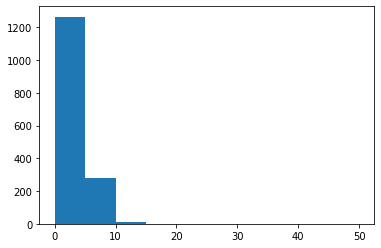

In [74]:
print(np.mean([len(most_similar_50_set_m[i].intersection(sanders_user_indices)) for i in sanders_user_indices]))
print(np.median([len(most_similar_50_set_m[i].intersection(sanders_user_indices)) for i in sanders_user_indices]))
print(sum([1 for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 5]))
print(sum([1 for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 10]))
print(np.mean([num_sanders[author_names[i]] for i in sanders_user_indices]))
print(np.mean([num_sanders[author_names[i]] for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 5]))
print(np.mean([num_sanders[author_names[i]] for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 10]))

plt.hist([len(most_similar_50_set_m[i].intersection(trump_user_indices)) for i in sanders_user_indices], range = (0,50))
plt.show()

2.823378291586384
3.0
292
12
14.23956326268465
17.65753424657534
11.416666666666666
103.33847141939627
133.93835616438355
63.833333333333336


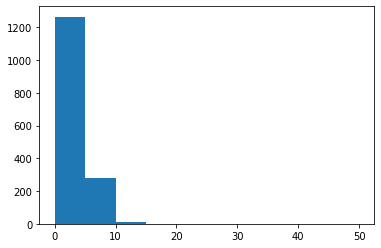

In [75]:
print(np.mean([len(most_similar_50_set_m[i].intersection(trump_user_indices)) for i in sanders_user_indices]))
print(np.median([len(most_similar_50_set_m[i].intersection(trump_user_indices)) for i in sanders_user_indices]))
print(sum([1 for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(trump_user_indices)) >= 5]))
print(sum([1 for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(trump_user_indices)) >= 10]))
print(np.mean([num_trump[author_names[i]] for i in sanders_user_indices]))
print(np.mean([num_trump[author_names[i]] for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(trump_user_indices)) >= 5]))
print(np.mean([num_trump[author_names[i]] for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(trump_user_indices)) >= 10]))
print(np.mean([num_sanders[author_names[i]] for i in sanders_user_indices]))
print(np.mean([num_sanders[author_names[i]] for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(trump_user_indices)) >= 5]))
print(np.mean([num_sanders[author_names[i]] for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(trump_user_indices)) >= 10]))

plt.hist([len(most_similar_50_set_m[i].intersection(trump_user_indices)) for i in sanders_user_indices], range = (0,50))
plt.show()

0.6210661528580603
0.0
49
0
5.449582530507386
57.87755102040816
103.33847141939627
112.77551020408163


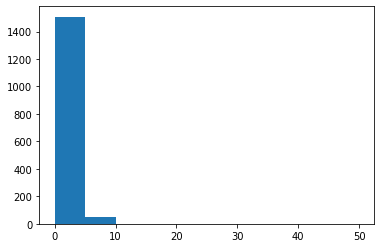

In [79]:
print(np.mean([len(most_similar_50_set_m[i].intersection(clinton_user_indices)) for i in sanders_user_indices]))
print(np.median([len(most_similar_50_set_m[i].intersection(clinton_user_indices)) for i in sanders_user_indices]))
print(sum([1 for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(clinton_user_indices)) >= 5]))
print(sum([1 for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(clinton_user_indices)) >= 10]))
print(np.mean([num_clinton[author_names[i]] for i in sanders_user_indices]))
print(np.mean([num_clinton[author_names[i]] for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(clinton_user_indices)) >= 5]))
# print(np.mean([num_clinton[author_names[i]] for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(clinton_user_indices)) >= 10]))
print(np.mean([num_sanders[author_names[i]] for i in sanders_user_indices]))
print(np.mean([num_sanders[author_names[i]] for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(clinton_user_indices)) >= 5]))
# print(np.mean([num_sanders[author_names[i]] for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(clinton_user_indices)) >= 10]))

plt.hist([len(most_similar_50_set_m[i].intersection(clinton_user_indices)) for i in sanders_user_indices], range = (0,50))
plt.show()

### Trump

3.189336235038085
3.0
215
18
97.14907508161045
109.76744186046511
49.111111111111114


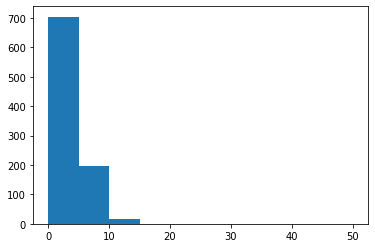

In [77]:
print(np.mean([len(most_similar_50_set_m[i].intersection(trump_user_indices)) for i in trump_user_indices]))
print(np.median([len(most_similar_50_set_m[i].intersection(trump_user_indices)) for i in trump_user_indices]))
print(sum([1 for i in trump_user_indices if len(most_similar_50_set_m[i].intersection(trump_user_indices)) >= 5]))
print(sum([1 for i in trump_user_indices if len(most_similar_50_set_m[i].intersection(trump_user_indices)) >= 10]))
print(np.mean([num_trump[author_names[i]] for i in trump_user_indices]))
print(np.mean([num_trump[author_names[i]] for i in trump_user_indices if len(most_similar_50_set_m[i].intersection(trump_user_indices)) >= 5]))
print(np.mean([num_trump[author_names[i]] for i in trump_user_indices if len(most_similar_50_set_m[i].intersection(trump_user_indices)) >= 10]))

plt.hist([len(most_similar_50_set_m[i].intersection(trump_user_indices)) for i in trump_user_indices], range = (0,50))
plt.show()

4.936887921653971
4.0
397
101
0
97.14907508161045
111.55667506297229
139.05940594059405
18.98150163220892
30.869017632241814
51.15841584158416


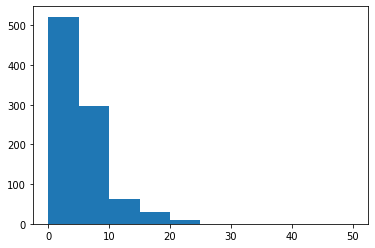

In [78]:
print(np.mean([len(most_similar_50_set_m[i].intersection(sanders_user_indices)) for i in trump_user_indices]))
print(np.median([len(most_similar_50_set_m[i].intersection(sanders_user_indices)) for i in trump_user_indices]))
print(sum([1 for i in trump_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 5]))
print(sum([1 for i in trump_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 10]))
print(sum([1 for i in trump_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 30]))
print(np.mean([num_trump[author_names[i]] for i in trump_user_indices]))
print(np.mean([num_trump[author_names[i]] for i in trump_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 5]))
print(np.mean([num_trump[author_names[i]] for i in trump_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 10]))
print(np.mean([num_sanders[author_names[i]] for i in trump_user_indices]))
print(np.mean([num_sanders[author_names[i]] for i in trump_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 5]))
print(np.mean([num_sanders[author_names[i]] for i in trump_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 10]))

plt.hist([len(most_similar_50_set_m[i].intersection(sanders_user_indices)) for i in trump_user_indices], range = (0,50))
plt.show()

0.528835690968444
0.0
21
0
1.0848748639825898
1.619047619047619
97.14907508161045
208.23809523809524


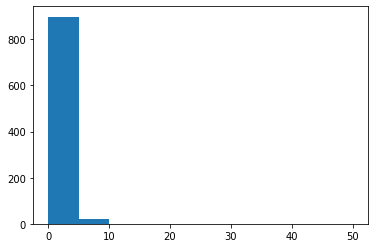

In [81]:
print(np.mean([len(most_similar_50_set_m[i].intersection(clinton_user_indices)) for i in trump_user_indices]))
print(np.median([len(most_similar_50_set_m[i].intersection(clinton_user_indices)) for i in trump_user_indices]))
print(sum([1 for i in trump_user_indices if len(most_similar_50_set_m[i].intersection(clinton_user_indices)) >= 5]))
print(sum([1 for i in trump_user_indices if len(most_similar_50_set_m[i].intersection(clinton_user_indices)) >= 10]))
print(np.mean([num_clinton[author_names[i]] for i in trump_user_indices]))
print(np.mean([num_clinton[author_names[i]] for i in trump_user_indices if len(most_similar_50_set_m[i].intersection(clinton_user_indices)) >= 5]))
# print(np.mean([num_clinton[author_names[i]] for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(clinton_user_indices)) >= 10]))
print(np.mean([num_trump[author_names[i]] for i in trump_user_indices]))
print(np.mean([num_trump[author_names[i]] for i in trump_user_indices if len(most_similar_50_set_m[i].intersection(clinton_user_indices)) >= 5]))
# print(np.mean([num_sanders[author_names[i]] for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(clinton_user_indices)) >= 10]))

plt.hist([len(most_similar_50_set_m[i].intersection(clinton_user_indices)) for i in trump_user_indices], range = (0,50))
plt.show()

### Clinton

1.489051094890511
1.0
20
0
95.81751824817518
210.65


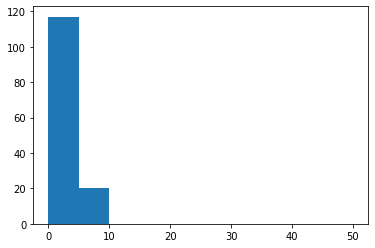

In [83]:
print(np.mean([len(most_similar_50_set_m[i].intersection(clinton_user_indices)) for i in clinton_user_indices]))
print(np.median([len(most_similar_50_set_m[i].intersection(clinton_user_indices)) for i in clinton_user_indices]))
print(sum([1 for i in clinton_user_indices if len(most_similar_50_set_m[i].intersection(clinton_user_indices)) >= 5]))
print(sum([1 for i in clinton_user_indices if len(most_similar_50_set_m[i].intersection(clinton_user_indices)) >= 10]))
print(np.mean([num_clinton[author_names[i]] for i in clinton_user_indices]))
print(np.mean([num_clinton[author_names[i]] for i in clinton_user_indices if len(most_similar_50_set_m[i].intersection(clinton_user_indices)) >= 5]))
# print(np.mean([num_clinton[author_names[i]] for i in clinton_user_indices if len(most_similar_50_set_m[i].intersection(clinton_user_indices)) >= 10]))

plt.hist([len(most_similar_50_set_m[i].intersection(clinton_user_indices)) for i in clinton_user_indices], range = (0,50))
plt.show()

7.08029197080292
5.0
77
39
95.81751824817518
127.98701298701299
143.28205128205127
125.0
176.7922077922078
89.71794871794872


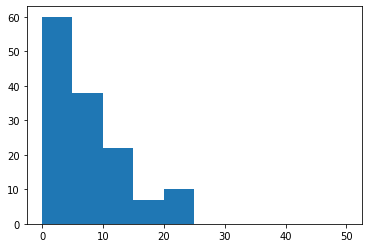

In [85]:
print(np.mean([len(most_similar_50_set_m[i].intersection(sanders_user_indices)) for i in clinton_user_indices]))
print(np.median([len(most_similar_50_set_m[i].intersection(sanders_user_indices)) for i in clinton_user_indices]))
print(sum([1 for i in clinton_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 5]))
print(sum([1 for i in clinton_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 10]))
print(np.mean([num_clinton[author_names[i]] for i in clinton_user_indices]))
print(np.mean([num_clinton[author_names[i]] for i in clinton_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 5]))
print(np.mean([num_clinton[author_names[i]] for i in clinton_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 10]))
print(np.mean([num_sanders[author_names[i]] for i in clinton_user_indices]))
print(np.mean([num_sanders[author_names[i]] for i in clinton_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 5]))
print(np.mean([num_sanders[author_names[i]] for i in clinton_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 10]))

plt.hist([len(most_similar_50_set_m[i].intersection(sanders_user_indices)) for i in clinton_user_indices], range = (0,50))
plt.show()

3.065693430656934
3.0
29
2
12.81021897810219
3.0344827586206895
12.5
95.81751824817518
69.06896551724138
102.5


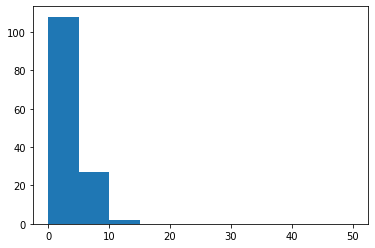

In [86]:
print(np.mean([len(most_similar_50_set_m[i].intersection(trump_user_indices)) for i in clinton_user_indices]))
print(np.median([len(most_similar_50_set_m[i].intersection(trump_user_indices)) for i in clinton_user_indices]))
print(sum([1 for i in clinton_user_indices if len(most_similar_50_set_m[i].intersection(trump_user_indices)) >= 5]))
print(sum([1 for i in clinton_user_indices if len(most_similar_50_set_m[i].intersection(trump_user_indices)) >= 10]))
print(np.mean([num_trump[author_names[i]] for i in clinton_user_indices]))
print(np.mean([num_trump[author_names[i]] for i in clinton_user_indices if len(most_similar_50_set_m[i].intersection(trump_user_indices)) >= 5]))
print(np.mean([num_trump[author_names[i]] for i in clinton_user_indices if len(most_similar_50_set_m[i].intersection(trump_user_indices)) >= 10]))
print(np.mean([num_clinton[author_names[i]] for i in clinton_user_indices]))
print(np.mean([num_clinton[author_names[i]] for i in clinton_user_indices if len(most_similar_50_set_m[i].intersection(trump_user_indices)) >= 5]))
print(np.mean([num_clinton[author_names[i]] for i in clinton_user_indices if len(most_similar_50_set_m[i].intersection(trump_user_indices)) >= 10]))

plt.hist([len(most_similar_50_set_m[i].intersection(trump_user_indices)) for i in clinton_user_indices], range = (0,50))
plt.show()